In [2]:
pip install torch torchvision torchaudio


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/216.1 MB 7.8 MB/s eta 0:00:28
    --------------------------------------- 4.2/216.1 MB 8.7 MB/s eta 0:00:25
   - -------------------------------------- 5.8/216.1 MB 8.4 MB/s eta 0:00:26
   - -------------------------------------- 7.3/216.1 MB 8.5 MB/s eta 0:00:25
   - -------------------------------------- 8.4/216.1 MB 8.0 MB/s eta 0:00:26
   - -------------------------------------- 8.4/216.1 MB 8.0 MB/s eta 0:00:26
   - -------------------------------------- 8.4/216.1 MB 8.0 MB/s eta 0:00:26
   - -------------------------------------- 10.7/216.1 MB 6.2 MB/s eta 0:00:34
   -- ----------------------------------

In [2]:
import numpy as np 
import scipy.io 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve  
)

import os 
import random 


In [3]:
mat = scipy.io.loadmat("D:/Football header/Football_header-/data.mat.mat")

X = mat['X']         
y = mat['y']         
Xval = mat['Xval']   
yval = mat['yval']   

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

Xval_tensor = torch.tensor(Xval, dtype=torch.float32)
yval_tensor = torch.tensor(yval, dtype=torch.float32)


train_dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(Xval_tensor, yval_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


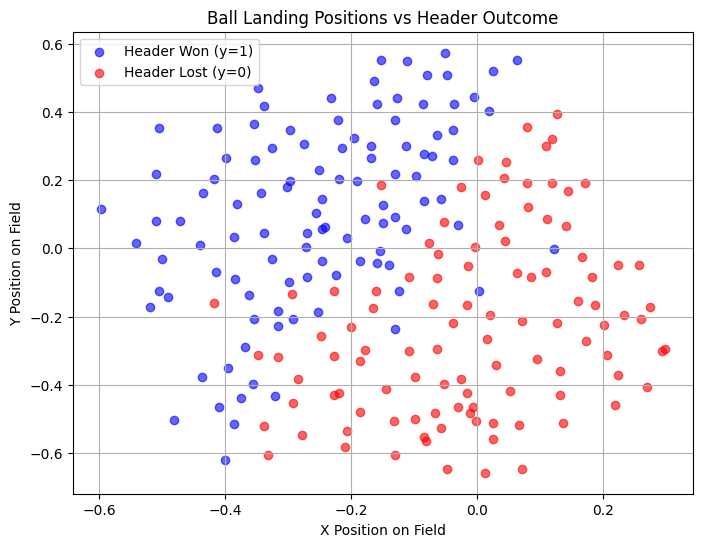

In [ ]:

X_np = X
y_np = y.flatten()


plt.figure(figsize=(8, 6))
plt.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], c='blue', label='Header Won (y=1)', alpha=0.6)
plt.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], c='red', label='Header Lost (y=0)', alpha=0.6)

plt.xlabel('X Position on Field')
plt.ylabel('Y Position on Field')
plt.title('Ball Landing Positions vs Header Outcome')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
class HeaderNet(nn.Module):
    def __init__(self, input_size=2, hidden1=20, hidden2=3, dropout_prob=0.3):
        super(HeaderNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)
        
        self.fc3 = nn.Linear(hidden2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x


In [6]:
model = HeaderNet()
print(model)


HeaderNet(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=20, out_features=3, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [7]:
# Load .mat dataset
data = scipy.io.loadmat("D:/Football header/Football_header-/data.mat.mat")

# Extract training and validation data
X_train = data['X']       # shape (m, 2)
y_train = data['y']       # shape (m, 1)
X_val = data['Xval']
y_val = data['yval']

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Wrap into TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [10]:
def train_model(model, train_loader, val_loader, num_epochs=1000, learning_rate=0.01, weight_decay=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # L2 regularization

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch).squeeze()
            y_batch = y_batch.view(-1)# shape (batch,)
            loss = criterion(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                y_val_pred = model(X_val_batch).squeeze()
                y_val_batch = y_val_batch.view(-1)
                val_loss = criterion(y_val_pred, y_val_batch)
                epoch_val_loss += val_loss.item()

        val_losses.append(epoch_val_loss / len(val_loader))

        # Print every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


In [11]:
model = HeaderNet()  # fresh instance
train_losses, val_losses = train_model(model, train_loader, val_loader)


Epoch 0/1000 | Train Loss: 0.6946 | Val Loss: 0.6956
Epoch 100/1000 | Train Loss: 0.3353 | Val Loss: 0.2774
Epoch 200/1000 | Train Loss: 0.3063 | Val Loss: 0.2716
Epoch 300/1000 | Train Loss: 0.3537 | Val Loss: 0.2751
Epoch 400/1000 | Train Loss: 0.3500 | Val Loss: 0.2705
Epoch 500/1000 | Train Loss: 0.3244 | Val Loss: 0.2740
Epoch 600/1000 | Train Loss: 0.3642 | Val Loss: 0.2781
Epoch 700/1000 | Train Loss: 0.3099 | Val Loss: 0.2722
Epoch 800/1000 | Train Loss: 0.2985 | Val Loss: 0.2713
Epoch 900/1000 | Train Loss: 0.3696 | Val Loss: 0.2774


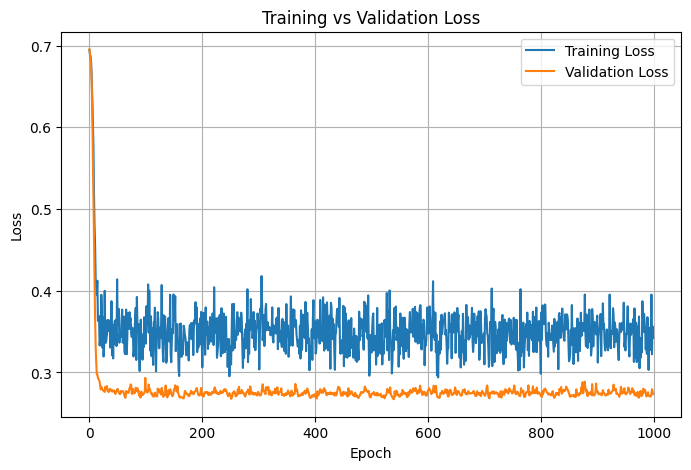

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
def evaluate_model(model, X_tensor, y_tensor, name="Set"):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor).squeeze()
        y_true = y_tensor.view(-1)
        y_pred_class = (y_pred >= 0.5).float()

        acc = accuracy_score(y_true, y_pred_class)
        f1 = f1_score(y_true, y_pred_class)
        prec = precision_score(y_true, y_pred_class)
        rec = recall_score(y_true, y_pred_class)
        auc = roc_auc_score(y_true, y_pred)

        print(f"\n📊 {name} Evaluation:")
        print(f"Accuracy:  {acc:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"ROC AUC:   {auc:.4f}")
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, y_pred_class))

# Evaluate on training set
evaluate_model(model, X_train_tensor, y_train_tensor, "Training")

# Evaluate on validation set
evaluate_model(model, X_val_tensor, y_val_tensor, "Validation")



📊 Training Evaluation:
Accuracy:  0.9242
F1 Score:  0.9245
Precision: 0.9245
Recall:    0.9245
ROC AUC:   0.9665

Confusion Matrix:
[[97  8]
 [ 8 98]]

📊 Validation Evaluation:
Accuracy:  0.9350
F1 Score:  0.9231
Precision: 0.9512
Recall:    0.8966
ROC AUC:   0.9562

Confusion Matrix:
[[109   4]
 [  9  78]]


In [16]:
def predict_and_report(model, X_tensor, y_tensor, label=""):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor).squeeze()
        y_class = (y_pred >= 0.5).float()
        accuracy = (y_class == y_tensor.view(-1)).float().mean().item()
        print(f"Accuracy on the {label} set: {accuracy:.4f}")
    return y_class.numpy()


In [17]:
print("On the training set:")
predictions_train = predict_and_report(model, X_train_tensor, y_train_tensor, label="training")

print("On the test set:")
predictions_test = predict_and_report(model, X_val_tensor, y_val_tensor, label="validation")


On the training set:
Accuracy on the training set: 0.9242
On the test set:
Accuracy on the validation set: 0.9350


without reg

In [18]:
model_without_reg = HeaderNet(dropout_prob=0.0)
train_losses_no_reg, val_losses_no_reg = train_model(
    model_without_reg, 
    train_loader, 
    val_loader, 
    learning_rate=0.01, 
    weight_decay=0.0  # ❌ no L2
)


Epoch 0/1000 | Train Loss: 0.6967 | Val Loss: 0.6750
Epoch 100/1000 | Train Loss: 0.2157 | Val Loss: 0.3145
Epoch 200/1000 | Train Loss: 0.1975 | Val Loss: 0.3407
Epoch 300/1000 | Train Loss: 0.1830 | Val Loss: 0.3770
Epoch 400/1000 | Train Loss: 0.1819 | Val Loss: 0.4200
Epoch 500/1000 | Train Loss: 0.2009 | Val Loss: 0.4832
Epoch 600/1000 | Train Loss: 0.1713 | Val Loss: 0.5316
Epoch 700/1000 | Train Loss: 0.1848 | Val Loss: 0.5682
Epoch 800/1000 | Train Loss: 0.1728 | Val Loss: 0.5824
Epoch 900/1000 | Train Loss: 0.1748 | Val Loss: 0.6238


In [19]:
model_with_reg = HeaderNet(dropout_prob=0.3)
train_losses_reg, val_losses_reg = train_model(
    model_with_reg, 
    train_loader, 
    val_loader, 
    learning_rate=0.01, 
    weight_decay=0.01  # ✅ L2
)


Epoch 0/1000 | Train Loss: 0.6917 | Val Loss: 0.6895
Epoch 100/1000 | Train Loss: 0.3335 | Val Loss: 0.2752
Epoch 200/1000 | Train Loss: 0.3663 | Val Loss: 0.2733
Epoch 300/1000 | Train Loss: 0.3368 | Val Loss: 0.2720
Epoch 400/1000 | Train Loss: 0.3374 | Val Loss: 0.2715
Epoch 500/1000 | Train Loss: 0.3211 | Val Loss: 0.2714
Epoch 600/1000 | Train Loss: 0.3379 | Val Loss: 0.2723
Epoch 700/1000 | Train Loss: 0.3386 | Val Loss: 0.2727
Epoch 800/1000 | Train Loss: 0.3564 | Val Loss: 0.2808
Epoch 900/1000 | Train Loss: 0.3190 | Val Loss: 0.2755


In [21]:
print("📊 Without Regularization:")
evaluate_model(model_without_reg, X_val_tensor, y_val_tensor, "Validation")

print("\n📊 With Regularization:")
evaluate_model(model_with_reg, X_val_tensor, y_val_tensor, "Validation")


📊 Without Regularization:

📊 Validation Evaluation:
Accuracy:  0.9250
F1 Score:  0.9112
Precision: 0.9390
Recall:    0.8851
ROC AUC:   0.9403

Confusion Matrix:
[[108   5]
 [ 10  77]]

📊 With Regularization:

📊 Validation Evaluation:
Accuracy:  0.9250
F1 Score:  0.9102
Precision: 0.9500
Recall:    0.8736
ROC AUC:   0.9563

Confusion Matrix:
[[109   4]
 [ 11  76]]


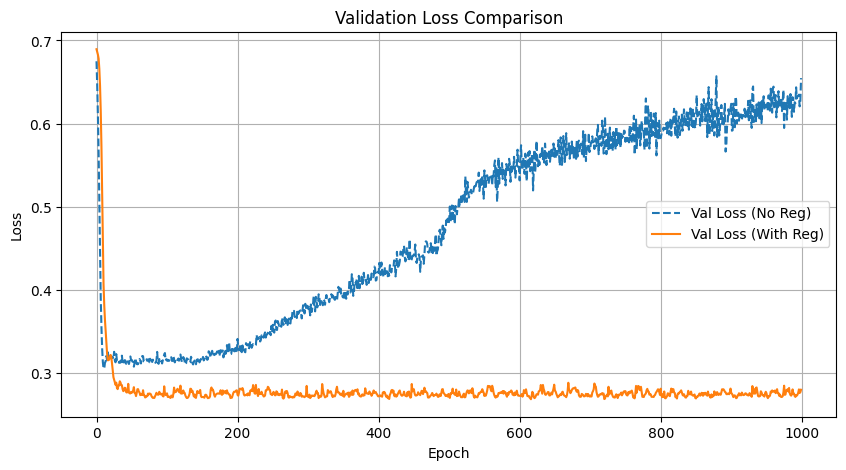

In [22]:
plt.figure(figsize=(10,5))
plt.plot(val_losses_no_reg, label="Val Loss (No Reg)", linestyle='--')
plt.plot(val_losses_reg, label="Val Loss (With Reg)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()


 Training Function for L1

In [23]:
def train_model_l1(model, train_loader, val_loader, num_epochs=1000, learning_rate=0.01, weight_decay=0.0, l1_lambda=0.0):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # L2 if used

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch).squeeze()
            y_batch = y_batch.view(-1)
            loss = criterion(y_pred, y_batch)

            # L1 penalty
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                y_val_pred = model(X_val_batch).squeeze()
                y_val_batch = y_val_batch.view(-1)
                val_loss = criterion(y_val_pred, y_val_batch)

                # L1 penalty (optional, you can include it or not for val)
                if l1_lambda > 0:
                    l1_norm = sum(p.abs().sum() for p in model.parameters())
                    val_loss += l1_lambda * l1_norm

                epoch_val_loss += val_loss.item()

        val_losses.append(epoch_val_loss / len(val_loader))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


In [24]:
# 1. No regularization
model_no_reg = HeaderNet(dropout_prob=0.0)
train_losses_none, val_losses_none = train_model_l1(model_no_reg, train_loader, val_loader, weight_decay=0.0, l1_lambda=0.0)

# 2. L2 regularization
model_l2 = HeaderNet(dropout_prob=0.3)
train_losses_l2, val_losses_l2 = train_model_l1(model_l2, train_loader, val_loader, weight_decay=0.01, l1_lambda=0.0)

# 3. L1 regularization
model_l1 = HeaderNet(dropout_prob=0.3)
train_losses_l1, val_losses_l1 = train_model_l1(model_l1, train_loader, val_loader, weight_decay=0.0, l1_lambda=0.001)


Epoch 0/1000 | Train Loss: 0.7257 | Val Loss: 0.6899
Epoch 100/1000 | Train Loss: 0.2451 | Val Loss: 0.3819
Epoch 200/1000 | Train Loss: 0.2256 | Val Loss: 0.3528
Epoch 300/1000 | Train Loss: 0.2477 | Val Loss: 0.3390
Epoch 400/1000 | Train Loss: 0.2293 | Val Loss: 0.3237
Epoch 500/1000 | Train Loss: 0.2283 | Val Loss: 0.3151
Epoch 600/1000 | Train Loss: 0.2239 | Val Loss: 0.3070
Epoch 700/1000 | Train Loss: 0.2264 | Val Loss: 0.3062
Epoch 800/1000 | Train Loss: 0.2464 | Val Loss: 0.3118
Epoch 900/1000 | Train Loss: 0.2286 | Val Loss: 0.3090
Epoch 0/1000 | Train Loss: 0.7087 | Val Loss: 0.6824
Epoch 100/1000 | Train Loss: 0.3640 | Val Loss: 0.2778
Epoch 200/1000 | Train Loss: 0.3572 | Val Loss: 0.2781
Epoch 300/1000 | Train Loss: 0.4028 | Val Loss: 0.2734
Epoch 400/1000 | Train Loss: 0.3358 | Val Loss: 0.2743
Epoch 500/1000 | Train Loss: 0.3397 | Val Loss: 0.2736
Epoch 600/1000 | Train Loss: 0.3604 | Val Loss: 0.2730
Epoch 700/1000 | Train Loss: 0.3762 | Val Loss: 0.2774
Epoch 800/1000

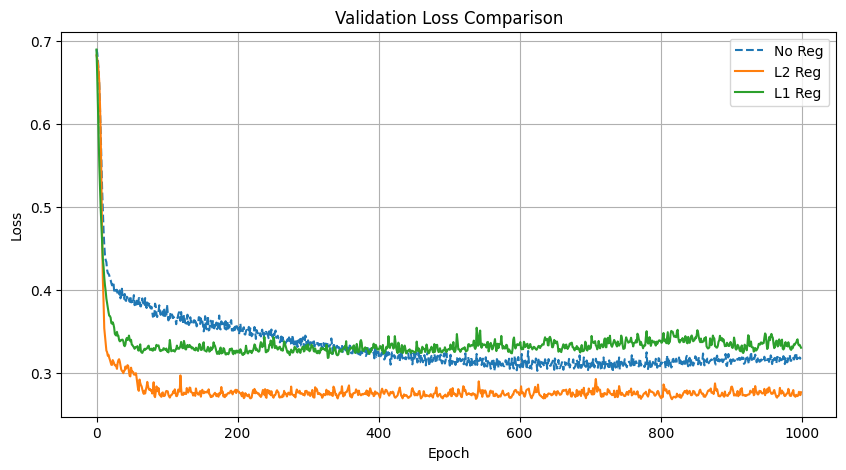

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(val_losses_none, label="No Reg", linestyle='--')
plt.plot(val_losses_l2, label="L2 Reg")
plt.plot(val_losses_l1, label="L1 Reg")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


In [26]:
def plot_decision_boundary_pytorch(model, X, y, title="Decision Boundary"):
    model.eval()

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    
    with torch.no_grad():
        Z = model(grid_tensor).cpu().numpy()
        Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap=plt.cm.RdBu, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=plt.cm.RdBu, edgecolors='k')
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')


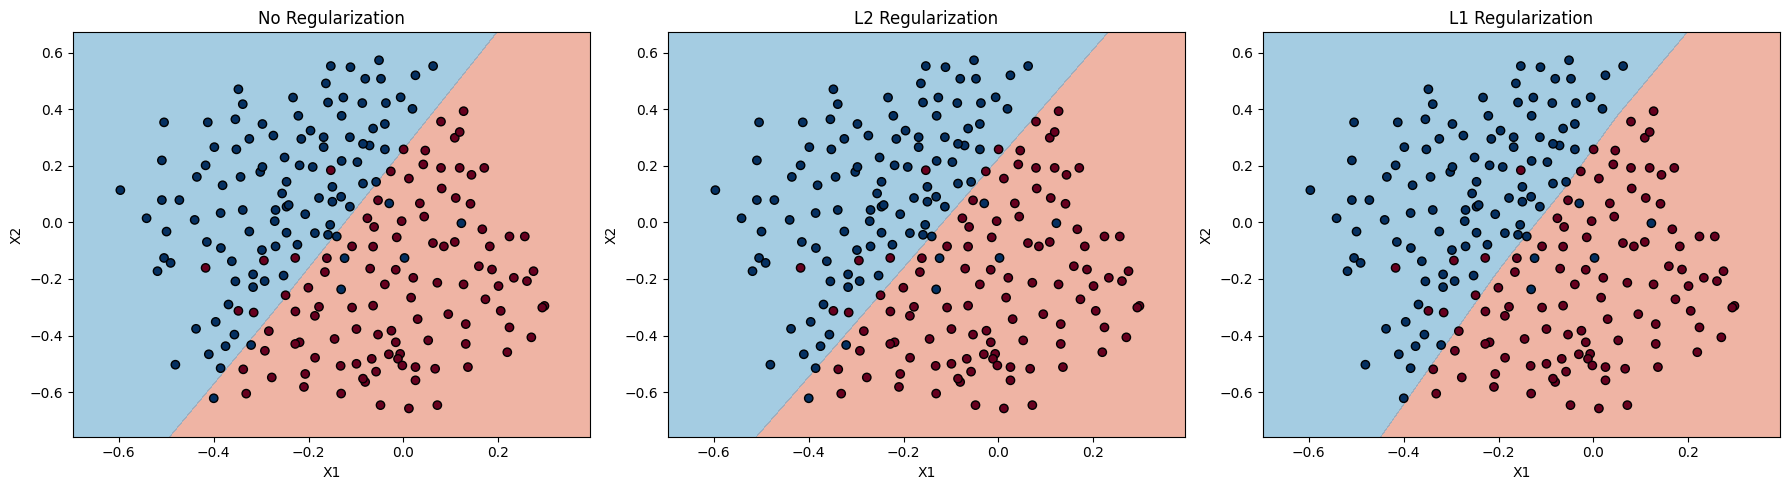

In [27]:
X_numpy = X_train_tensor.numpy()
y_numpy = y_train_tensor.numpy()

plt.figure(figsize=(18, 5))

# No Regularization
plt.subplot(1, 3, 1)
plot_decision_boundary_pytorch(model_no_reg, X_numpy, y_numpy, title="No Regularization")

# L2 Regularization
plt.subplot(1, 3, 2)
plot_decision_boundary_pytorch(model_l2, X_numpy, y_numpy, title="L2 Regularization")

# L1 Regularization
plt.subplot(1, 3, 3)
plot_decision_boundary_pytorch(model_l1, X_numpy, y_numpy, title="L1 Regularization")

plt.tight_layout()
plt.show()


In [30]:
# Define the model with dropout
model_dropout_only = HeaderNet(dropout_prob=0.3)

# Train the model (no L1 or L2)
train_losses_dropout, val_losses_dropout = train_model_l1(
    model_dropout_only,
    train_loader,
    val_loader,
    num_epochs=1000,
    learning_rate=0.01,
    weight_decay=0.0,     # No L2
    l1_lambda=0.0         # No L1
)


Epoch 0/1000 | Train Loss: 0.7103 | Val Loss: 0.7086
Epoch 100/1000 | Train Loss: 0.2846 | Val Loss: 0.3434
Epoch 200/1000 | Train Loss: 0.2771 | Val Loss: 0.3795
Epoch 300/1000 | Train Loss: 0.2805 | Val Loss: 0.4316
Epoch 400/1000 | Train Loss: 0.2800 | Val Loss: 0.4368
Epoch 500/1000 | Train Loss: 0.2780 | Val Loss: 0.5005
Epoch 600/1000 | Train Loss: 0.2747 | Val Loss: 0.5650
Epoch 700/1000 | Train Loss: 0.2768 | Val Loss: 0.6586
Epoch 800/1000 | Train Loss: 0.3043 | Val Loss: 0.6743
Epoch 900/1000 | Train Loss: 0.3167 | Val Loss: 0.8314


In [31]:
evaluate_model(model_dropout_only, X_val_tensor, y_val_tensor, "Validation (Dropout only)")



📊 Validation (Dropout only) Evaluation:
Accuracy:  0.9250
F1 Score:  0.9143
Precision: 0.9091
Recall:    0.9195
ROC AUC:   0.9521

Confusion Matrix:
[[105   8]
 [  7  80]]


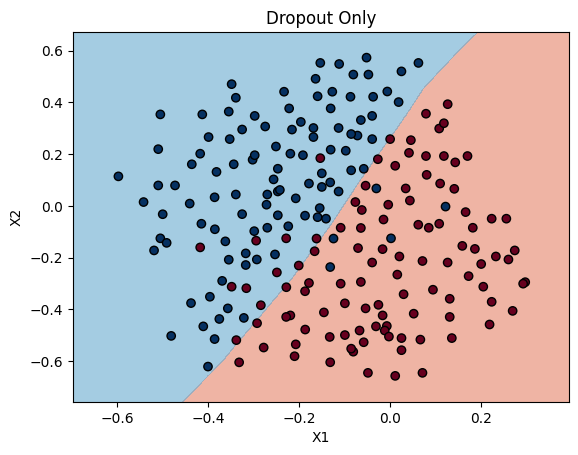

In [32]:
plot_decision_boundary_pytorch(model_dropout_only, X_numpy, y_numpy, title="Dropout Only")


In [36]:
# Create directory if needed
import os
os.makedirs("saved_models", exist_ok=True)

# Save each model
torch.save(model_no_reg.state_dict(), "saved_models/model_no_reg.pt")
torch.save(model_l2.state_dict(), "saved_models/model_l2.pt")
torch.save(model_l1.state_dict(), "saved_models/model_l1.pt")
torch.save(model_dropout_only.state_dict(), "saved_models/model_dropout.pt")

print("✅ All models saved to 'saved_models/' folder.")


✅ All models saved to 'saved_models/' folder.


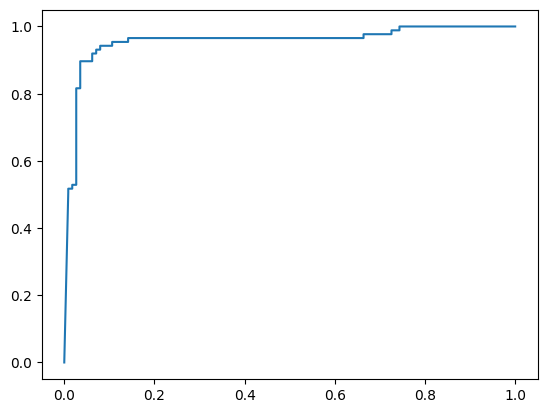

In [37]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X, y, label):
    model.eval()
    with torch.no_grad():
        y_scores = model(torch.tensor(X, dtype=torch.float32)).squeeze().numpy()
    fpr, tpr, _ = roc_curve(y, y_scores)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.2f})")

# Example:
plot_roc_curve(model_no_reg, X_val_tensor.numpy(), y_val_tensor.numpy(), "No Reg")


In [38]:
from sklearn.metrics import confusion_matrix, classification_report

def print_classification_metrics(model, X, y_true):
    model.eval()
    with torch.no_grad():
        y_pred = model(X).squeeze()
        y_class = (y_pred >= 0.5).float()
    print(confusion_matrix(y_true, y_class))
    print(classification_report(y_true, y_class, digits=3))


In [39]:
pip install shap lime


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached scikit_image-0.25.2-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2025.5.10-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ---------------------------------------- 0.0/544.3 kB ? eta -:--:--
   ---------------------------------------- 544.3/544.3 kB 9.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 12.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ----- ---------------------------------- 3.9/30.3 MB 19.5 MB/s eta 0:00:02
   ---------- ----------------------------- 8.1/30.3 MB 19.4 MB/s eta 0:00:02
   --------------- ------------------

  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [40]:
import shap

# Define a simple prediction function (as SHAP expects)
def predict_fn(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
    model_dropout_only.eval()
    with torch.no_grad():
        preds = model_dropout_only(x_tensor).numpy()
    return preds

# Use a sample from training data for SHAP
X_background = X_train_tensor[:100].numpy()

explainer = shap.Explainer(predict_fn, X_background)
shap_values = explainer(X_val_tensor.numpy())


c:\Users\BIT\.conda\envs\parking_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ExactExplainer explainer: 201it [00:15, 12.92it/s]                           


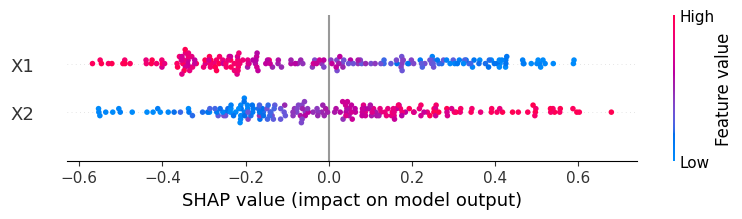

In [41]:
shap.summary_plot(shap_values, X_val_tensor.numpy(), feature_names=["X1", "X2"])


In [45]:
def lime_predict_fn(x):
    with torch.no_grad():
        logits = model_dropout_only(torch.tensor(x, dtype=torch.float32)).detach().numpy()
        probs = np.concatenate([1 - logits, logits], axis=1)  # convert to shape [N, 2]
    return probs


In [46]:
from lime import lime_tabular

# Setup LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_tensor.numpy(),
    mode="classification",
    feature_names=["X1", "X2"],
    class_names=["Lose", "Win"],
    discretize_continuous=True
)

# Explain a specific instance
i = 0  # choose index
lime_exp = lime_explainer.explain_instance(
    data_row=X_val_tensor[i].numpy(),
    predict_fn=lime_predict_fn
)

# Show explanation
lime_exp.show_in_notebook()
